In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import shap

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import xgboost as xgb



# Assess data quality

In [20]:
df = pd.read_excel("../paper/artifacts/datasets/Stanik_dataset/DATASET_not_downsampled.xlsx", index_col=0)

In [21]:
print(df.shape)
print(df.columns)

(6070, 3)
Index(['review', 'kano_labels', 'labels'], dtype='object')


In [22]:
df.head()

,review,kano_labels,labels
0,No good. It will let me make them but I can't ...,B,0
1,Can not edit PDF :-( I just wanna note somethi...,B,0
2,Not good Why i cannot clear chat history. Come...,P,3
3,Wish someone warned me before . . . . . . no s...,B,0
4,Just ok For God's sake we need a new icon and ...,B,0


In [23]:
# Check that all labels only associated with 1 kano label
df.groupby("labels")["kano_labels"].nunique()

labels
0    1
1    1
2    1
3    1
Name: kano_labels, dtype: int64

In [24]:
# Check data imbalance
df.groupby("kano_labels").size()

kano_labels
B    1440
D     648
I    2452
P    1530
dtype: int64

In [25]:
# Check for nulls
df.describe(include="all")

,review,kano_labels,labels
count,6070,6070,6070.00000
unique,6070,4,NaN
top,No good. It will let me make them but I can't ...,I,NaN
freq,1,2452,NaN
mean,NaN,NaN,1.67084
std,NaN,NaN,1.09526
min,NaN,NaN,0.00000
25%,NaN,NaN,1.00000
50%,NaN,NaN,2.00000
75%,NaN,NaN,3.00000


# Create train test data

In [26]:
X = df[[c for c in df.columns if c not in ["kano_labels", "labels"]]]
y = df["labels"]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

train_data = train_X.assign(labels=train_y.values)
test_data = test_X.assign(labels=test_y.values)

In [27]:
train_data.to_csv("../data/train.csv")
test_data.to_csv("../data/test.csv")

# Get baseline performance

In [30]:
df.groupby(["kano_labels", "labels"]).size()

kano_labels  labels
B            0         1440
D            1          648
I            2         2452
P            3         1530
dtype: int64

If the model always predicted I - the most popular class - it would have accuracy of 40% on the training set.

# Classification using BERT embedding

In [31]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def get_embedding(review):
    # TODO: Meaning of the diff bits of this tokenizer
    inputs = tokenizer(review, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)

    # TODO: Why mean of last layer hidden states as sentence embedding
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

def get_centroid(embeddings):
    return np.mean(embeddings, axis=0)

def get_nearest_label(embedding, centroid_dict):
    nearest_label = ""
    nearest_label_distance = float("inf")
    for label, centroid in centroid_dict.items():
        # Euclidean distance
        label_distance = np.linalg.norm(embedding - centroid)
        if label_distance < nearest_label_distance:
            nearest_label = label
            nearest_label_distance = label_distance

    return pd.Series([nearest_label, nearest_label_distance])

def calculate_centroids(df):
    # Transform the data
    df["embedding"] = df["review"].apply(get_embedding)

    # Get embeddings for all sentences of each type
    label_embeddings = df.groupby("labels")["embedding"].apply(list).reset_index().rename(columns={"embedding": "embeddings"})

    # Get centroids for each label
    label_embeddings["centroid"] = label_embeddings["embeddings"].apply(get_centroid)

    return label_embeddings


def classify_reviews(df, label_embeddings):
    
    centroid_dict = {row["labels"]: row["centroid"][0] for row in label_embeddings.to_dict(orient="records")}
    
    # Transform the data
    df["embedding"] = df["review"].apply(get_embedding)

    # Label data
    df[["nearest_label", "nearest_label_distance"]] = df["embedding"].apply(lambda x: get_nearest_label(x, centroid_dict))

    return df


In [32]:
centroid_df = calculate_centroids(train_data)
centroid_df[["labels", "centroid"]].to_json("../data/bert_embedding_approach/centroids.json")
centroid_df.to_json("../data/bert_embedding_approach/centroids_full.json")

Accuracy: 0.6820428336079077
Recall: 0.6820428336079077
Precision: 0.7298511057944531


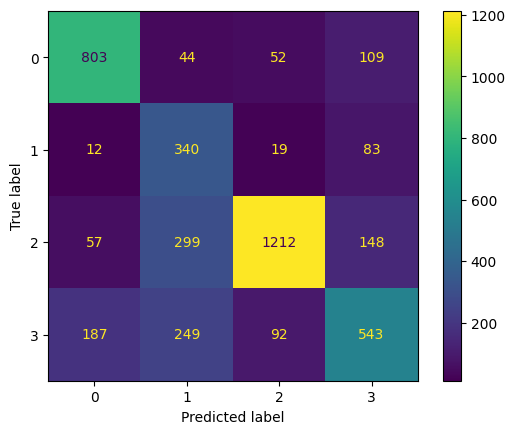

In [33]:
# Accuracy on training set

# run classification
train_output = classify_reviews(train_data, centroid_df)
train_output[["review", "labels", "nearest_label", "nearest_label_distance"]].to_csv("../data/bert_embedding_approach/train_labelled.csv")

# check accuracy, precision, recall
accuracy = metrics.accuracy_score(train_output["labels"], train_output["nearest_label"])
print(f"Accuracy: {accuracy}")
recall_score = metrics.recall_score(train_output["labels"], train_output["nearest_label"], average="weighted")
print(f"Recall: {recall_score}")
precision_score = metrics.precision_score(train_output["labels"], train_output["nearest_label"], average="weighted")
print(f"Precision: {precision_score}")

# confusion matrix
cm = metrics.confusion_matrix(train_output["labels"], train_output["nearest_label"])
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()

Accuracy: 0.6814936847885777
Recall: 0.6814936847885777
Precision: 0.7273515157176651


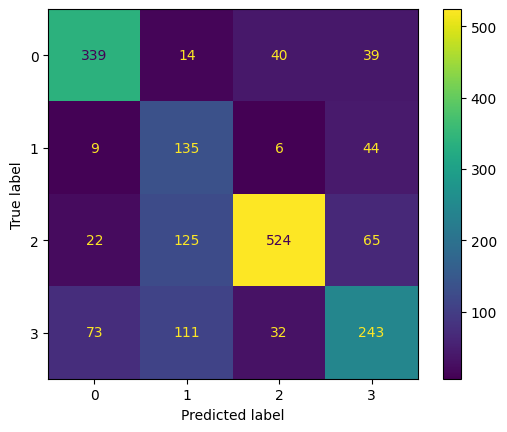

In [34]:
# Accuracy on test set

# run classification
test_output = classify_reviews(test_data, centroid_df)
test_output[["review", "labels", "nearest_label", "nearest_label_distance"]].to_csv("../data/bert_embedding_approach/test_labelled.csv")

# check accuracy, precision, recall
accuracy = metrics.accuracy_score(test_output["labels"], test_output["nearest_label"])
print(f"Accuracy: {accuracy}")
recall_score = metrics.recall_score(test_output["labels"], test_output["nearest_label"], average="weighted")
print(f"Recall: {recall_score}")
precision_score = metrics.precision_score(test_output["labels"], test_output["nearest_label"], average="weighted")
print(f"Precision: {precision_score}")

# confusion matrix
cm = metrics.confusion_matrix(test_output["labels"], test_output["nearest_label"])
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()


In [47]:
# Explainability
# Understanding the clusters

# variance in distance to centroid within cluster
def get_distance_from_centroid(embeddings, centroid):
    distances = []
    for e in embeddings:
        distances.append(np.linalg.norm(e - centroid))

    return distances

def get_variance(distances):
    return np.var(distances, axis=0)

def get_mean(distances):
    return np.mean(distances, axis=0)

centroid_df["distances"] = centroid_df.apply(lambda x: get_distance_from_centroid(x["embeddings"], x["centroid"]), axis=1)
centroid_df["variance"] = centroid_df["distances"].apply(get_variance)
centroid_df["mean"] = centroid_df["distances"].apply(get_mean)
print(f"Mean distance of each cluster point to centroid:")
print(centroid_df['mean'])
print(f"Variance in distance of each cluster point to centroid:")
print(centroid_df['variance'])

# variance in distance between centroids of different clusters
inter_centroid_dist_df = centroid_df[["labels", "centroid"]].rename(columns={c: f"{c}_base" for c in centroid_df.columns})
inter_centroid_dist_df = inter_centroid_dist_df.merge(centroid_df[["labels", "centroid"]], how="cross")
inter_centroid_dist_df = inter_centroid_dist_df[inter_centroid_dist_df["labels"] != inter_centroid_dist_df["labels_base"]]
inter_centroid_dist_df["distance"] = inter_centroid_dist_df.apply(lambda x: np.linalg.norm(x["centroid_base"]-x["centroid"]), axis=1)

inter_centroid_variance = np.var(inter_centroid_dist_df["distance"], axis=0)
inter_centroid_mean = np.mean(inter_centroid_dist_df["distance"], axis=0)
print(f"Mean in distance between centroids of different clusters: {inter_centroid_mean}")
print(f"Variance in distance between centroids of different clusters: {inter_centroid_variance}")



Mean distance of each cluster point to centroid:
0    4.564696
1    4.348131
2    6.166257
3    4.761424
Name: mean, dtype: float32
Variance in distance of each cluster point to centroid:
0    1.223748
1    0.876115
2    1.099353
3    0.959601
Name: variance, dtype: float32
Mean in distance between centroids of different clusters: 2.4654922485351562
Variance in distance between centroids of different clusters: 0.8149585723876953


# Classification using XGBoost

In [36]:
# Create tfidf features
vectorizer = TfidfVectorizer(stop_words="english")
train_X_tfidf = vectorizer.fit_transform(train_data["review"])
train_y = train_data["labels"]

# Train classification model
model = xgb.XGBClassifier(object="multi:softmax", num_class=4)
model.fit(train_X_tfidf, train_y)



[11:08:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "object" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

Accuracy: 0.9258649093904449
Recall: 0.9258649093904449
Precision: 0.9286012090776128


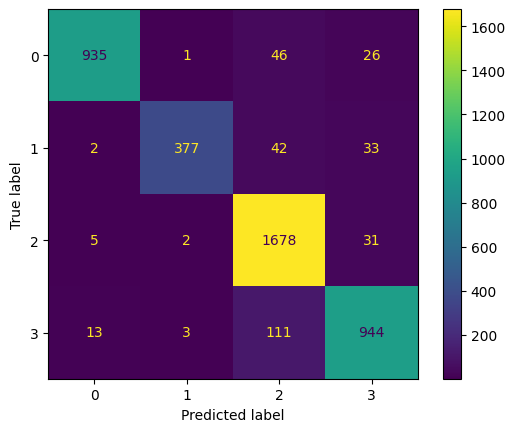

In [39]:
# Accuracy on training set

# run classification
train_X_tfidf = vectorizer.transform(train_data["review"])
train_y = train_data["labels"]
pred_y = model.predict(train_X_tfidf)
pd.Series(pred_y).to_csv("../data/xgboost_approach/train_predictions.csv")

# check accuracy, precision, recall
accuracy = metrics.accuracy_score(train_y, pred_y)
print(f"Accuracy: {accuracy}")
recall_score = metrics.recall_score(train_y, pred_y, average="weighted")
print(f"Recall: {recall_score}")
precision_score = metrics.precision_score(train_y, pred_y, average="weighted")
print(f"Precision: {precision_score}")

# confusion matrix
cm = metrics.confusion_matrix(train_y, pred_y)
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()

Accuracy: 0.7391543108182317
Recall: 0.7391543108182317
Precision: 0.730840772575905


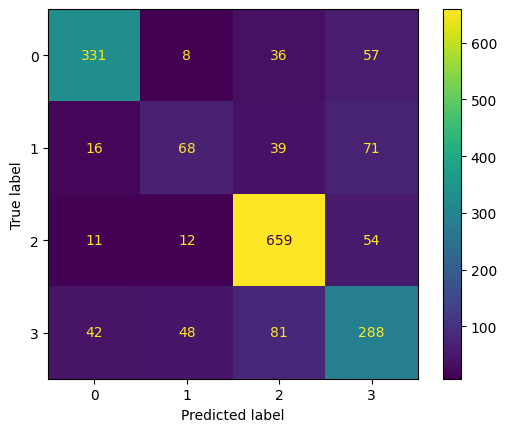

In [41]:
# Accuracy on test set

# run classification
test_X_tfidf = vectorizer.transform(test_data["review"])
test_y = test_data["labels"]
pred_y = model.predict(test_X_tfidf)
pd.Series(pred_y).to_csv("../data/xgboost_approach/test_predictions.csv")

# check accuracy, precision, recall
accuracy = metrics.accuracy_score(test_y, pred_y)
print(f"Accuracy: {accuracy}")
recall_score = metrics.recall_score(test_y, pred_y, average="weighted")
print(f"Recall: {recall_score}")
precision_score = metrics.precision_score(test_y, pred_y, average="weighted")
print(f"Precision: {precision_score}")

# confusion matrix
cm = metrics.confusion_matrix(test_y, pred_y)
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()

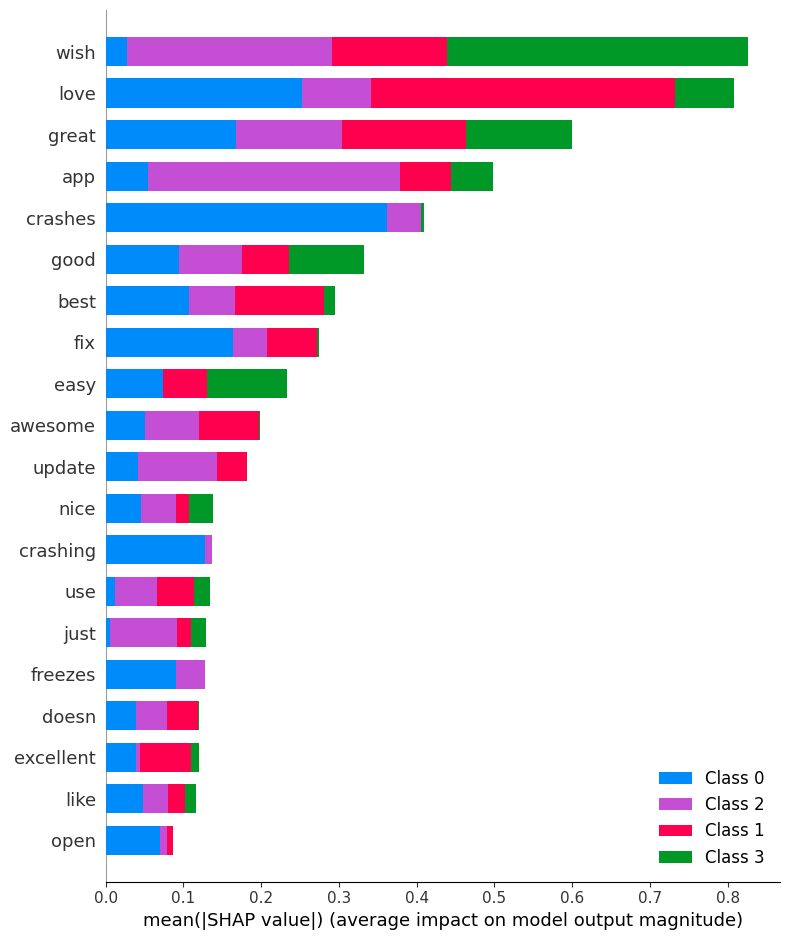

In [42]:
# Explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_X_tfidf)
shap.summary_plot(shap_values, train_X_tfidf, feature_names=vectorizer.get_feature_names_out())

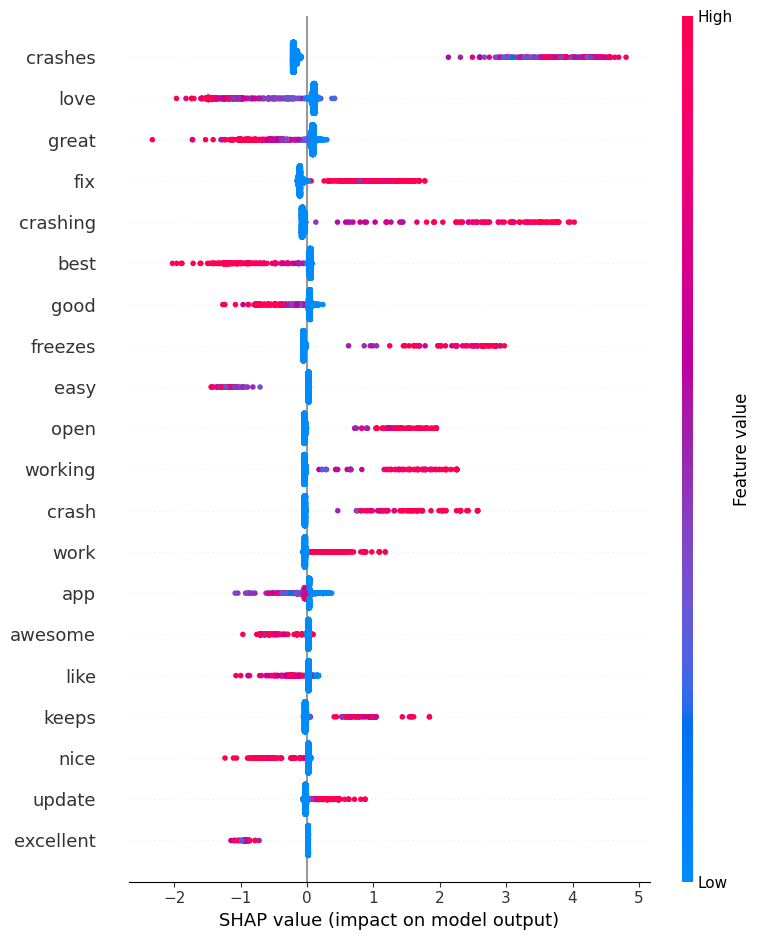

In [43]:
shap.summary_plot(shap_values[0], train_X_tfidf.toarray(), feature_names=vectorizer.get_feature_names_out())

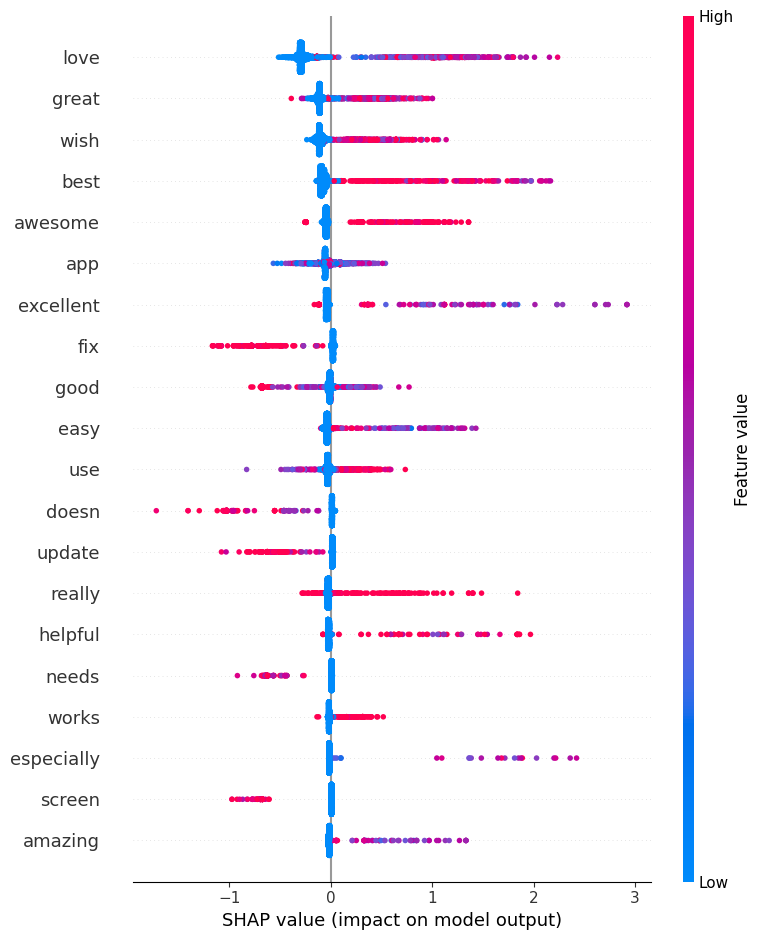

In [44]:
shap.summary_plot(shap_values[1], train_X_tfidf.toarray(), feature_names=vectorizer.get_feature_names_out())

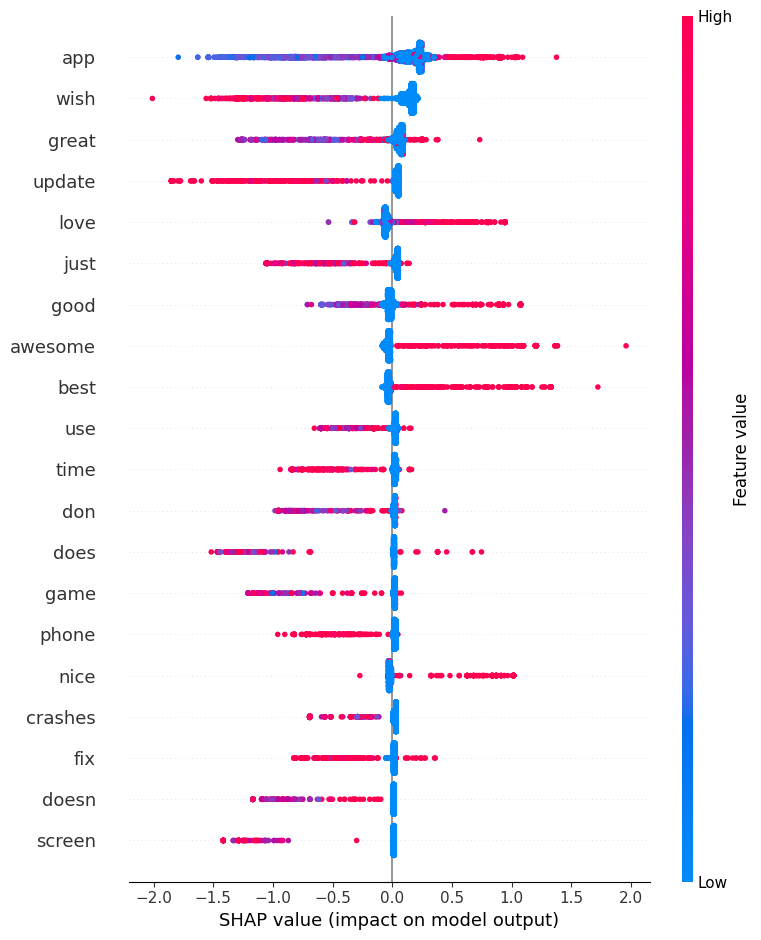

In [45]:
shap.summary_plot(shap_values[2], train_X_tfidf.toarray(), feature_names=vectorizer.get_feature_names_out())

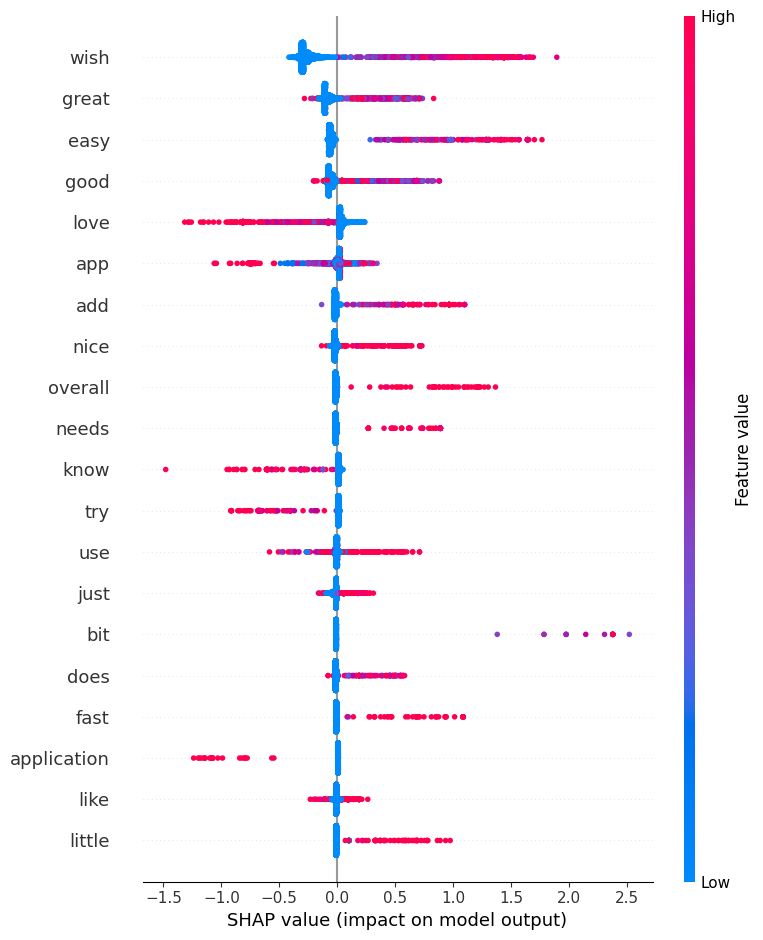

In [46]:
shap.summary_plot(shap_values[3], train_X_tfidf.toarray(), feature_names=vectorizer.get_feature_names_out())